# Fake news detection

In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [25]:
fake = pd.read_csv("/content/Fake.csv")
true = pd.read_csv("/content/True.csv")

In [26]:
fake.shape


(23481, 4)

In [27]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [39]:
# Add flag to track fake and real
fake['flag'] = 'fake'
true['flag'] = 'true'

In [29]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [30]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [31]:
# Check the data and save the data on csv file
data.head()
data.to_csv("data.csv", index=False)


In [32]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,flag
0,Trump SLAMS Canada By Using Example Border St...,It can easily be said that Donald Trump doesn ...,News,fake
1,So Much For Brussels Terror Victims…Let’s Play...,"Hey Barry, could you at least have enough resp...",politics,fake
2,Final death toll from London's Grenfell Tower ...,LONDON (Reuters) - The final death toll from t...,worldnews,true
3,FORMER ANTI-TRUMP ACTOR Calls Out The Left: ‘F...,Now here s a Hollywood actor who lives in real...,politics,fake
4,Senate Republicans ask Moore to withdraw as ne...,WASHINGTON (Reuters) - U.S. Senate Majority Le...,politicsNews,true


In [33]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,flag
0,It can easily be said that Donald Trump doesn ...,News,fake
1,"Hey Barry, could you at least have enough resp...",politics,fake
2,LONDON (Reuters) - The final death toll from t...,worldnews,true
3,Now here s a Hollywood actor who lives in real...,politics,fake
4,WASHINGTON (Reuters) - U.S. Senate Majority Le...,politicsNews,true


In [34]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,flag
0,it can easily be said that donald trump doesn ...,News,fake
1,"hey barry, could you at least have enough resp...",politics,fake
2,london (reuters) - the final death toll from t...,worldnews,true
3,now here s a hollywood actor who lives in real...,politics,fake
4,washington (reuters) - u.s. senate majority le...,politicsNews,true


In [40]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [41]:
# Check
data.head()

,text,subject,flag
0,easily said donald trump clue hears things cli...,News,fake
1,hey barry could least enough respect terror vi...,politics,fake
2,london reuters final death toll fire destroyed...,worldnews,true
3,hollywood actor lives reality left still delus...,politics,fake
4,washington reuters us senate majority leader m...,politicsNews,true


In [37]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
data.head()

,text,subject,flag
0,easily said donald trump clue hears things cli...,News,fake
1,hey barry could least enough respect terror vi...,politics,fake
2,london reuters final death toll fire destroyed...,worldnews,true
3,hollywood actor lives reality left still delus...,politics,fake
4,washington reuters us senate majority leader m...,politicsNews,true


## Basic data exploration

flag
fake    23481
true    21417
Name: text, dtype: int64


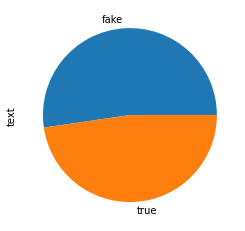

In [44]:
# How many fake and ture news?

print(data.groupby(['flag'])['text'].count())
data.groupby(['flag'])['text'].count().plot(kind="pie")
plt.show()

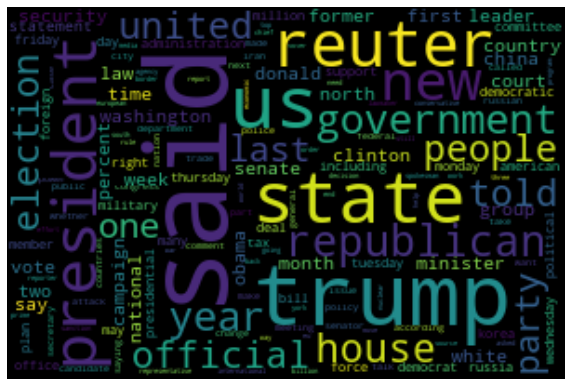

In [46]:
# What is the most word in real news? Shoing as Word cloud 

from wordcloud import WordCloud

real_data = data[data["flag"] == "true"]
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width= 300, height= 200,
                          max_font_size = 60,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
# This methode to count the most frequent words on the text 
    
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

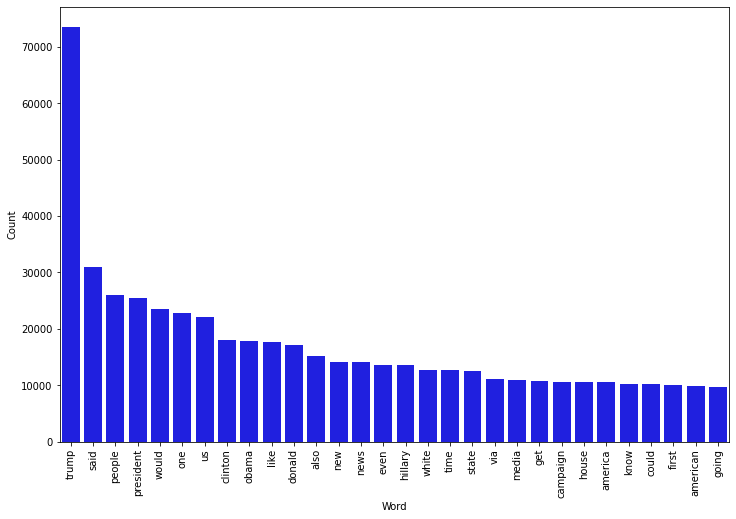

In [49]:
# What is most recurring words in fake news ?

counter(data[data["flag"] == "fake"], "text", 30)

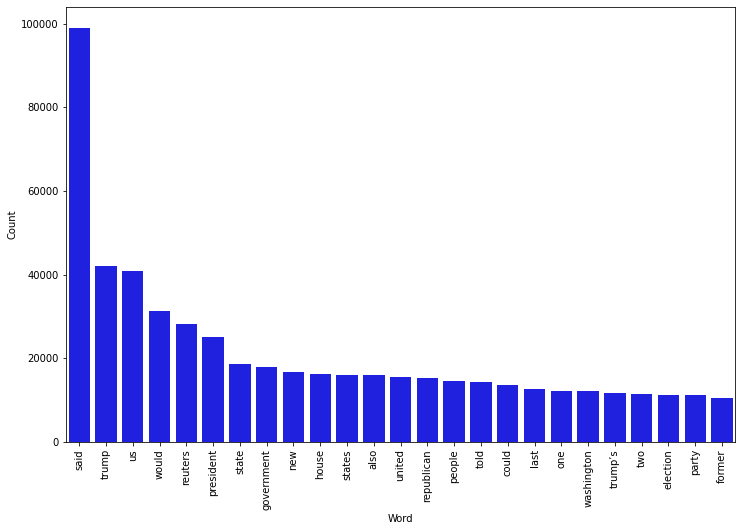

In [ ]:
#What is most recurring words in true news ?

counter(data[data["flag"] == "true"], "text", 25)

## Modeling

In [53]:

from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Peparing the data

In [54]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.flag, test_size=0.2, random_state=42)

### Logistic regression

In [57]:
from os import times
import time
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
t0 = time.time()
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
time_pred = time.time() - t0

print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(f'time = {time_pred: .3f} seconds')


accuracy: 98.78%
time =  15.912 seconds


Confusion matrix, without normalization


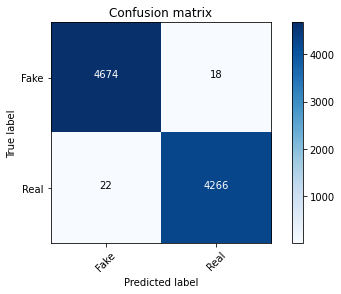

In [60]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [61]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])

t0 = time.time()

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)

time_pred = time.time() - t0
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(f'time = {time_pred: .3f} seconds')


accuracy: 99.55%
time =  28.096 seconds


Confusion matrix, without normalization


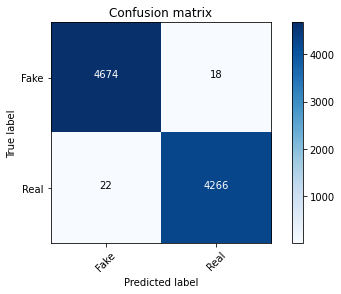

In [62]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])


t0 = time.time()
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
time_pred = time.time() - t0

print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(f'time = {time_pred: .3f} seconds')


accuracy: 99.05%
time =  73.054 seconds


Confusion matrix, without normalization


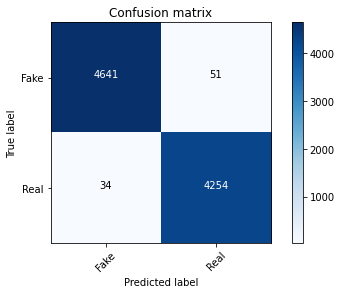

In [64]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])